In [1]:
import os
import math
import pickle
import datetime
import numpy as np
import array
import matplotlib.pyplot as plt
#import modape
from modape.whittaker import ws2d, ws2doptv, ws2doptvp
#from modape.utils import DateHelper, fromjulian

from osgeo import gdal
import h5py

In [2]:
def tif2array(file_path, dtype=np.uint8):
    """
    read GeoTiff and convert to numpy.ndarray.
    inputs:
        file_path (str) : file path of the input GeoTiff file
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive
    """
    dataset = gdal.Open(file_path, gdal.GA_ReadOnly)

    if dataset is None:
        return None

    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=dtype)

    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        image[:, :, b] = band.ReadAsArray()#buf_type=gdalconst.GDT_Byte)

    #image = image[2:-2,2:-2,:]

    return image

In [3]:
# set path to data
path_dir = '/home/philipp/Data/modis/raw/'
files = os.listdir(path_dir)

start_year = 2009
end_year = 2021

#find
files_ndvi=[]
for n in files:
    if n[-8:] == 'NDVI.tif':
        files_ndvi.append(n)

files_ndvi = np.array(sorted(files_ndvi))

print(files_ndvi.size)
files_ndvi

591


array(['MOD13Q1.A2009001.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009017.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009033.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009049.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009065.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009081.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009097.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009113.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009129.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009145.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009161.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009177.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009193.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009209.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009225.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009241.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009257.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009273.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009289.250m_16_days_NDVI.tif',
       'MOD13Q1.A2009305.250m_16_days_NDVI.tif',
       'MOD13Q1.A200

### read modis tif images

In [4]:
# read images from disk
imgs = []
for i in files_ndvi[0:len(files_ndvi)]:
    imgs.append(tif2array(path_dir + i, dtype=np.int16))

# create numpy 3D array
images = np.concatenate(imgs, axis=2)
print(images.shape)

# free RAM
del imgs

(1299, 1864, 591)


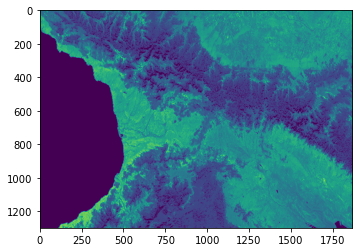

In [5]:
plt.imshow(images[:,:,3])

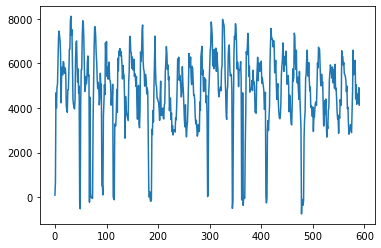

In [6]:
plt.plot(images[800,1000])

In [7]:
np.quantile(images[288,288], np.arange(0,1.1,0.1))

array([-3000.,  5020.,  5432.,  5933.,  6726.,  7984.,  8405.,  8620.,
        8790.,  8897.,  9359.])

In [8]:
np.quantile(images[800,1000], np.arange(0,1.1,0.1))

array([-751., 2994., 3653., 4159., 4707., 5066., 5420., 5754., 6087.,
       6669., 8119.])

### create indices

Data is stored as 16 day composit NDVI images for the two **modis** satelites **aqua** and **terra**.
The date of the 16 day mean aquisition is included in the file name:

In order to create dayly data the data has to be inserted into a array with the date

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|x|o|o|o|o|o|o|o|x|o|o|o|o|o|o|x|o|o|o|o|

1. create array with the corespnding indices
2. create 1D array of ones as a time line of one pixel corresponding to 365 days and x years
3. set values in 1D array from the observed data
4. create weights for whittaker smothing
5. whittaker smothing of one pixel

In [9]:
def create_indices(num_img):

    # create indices
    idx_list = []

    full_years = math.floor(num_img/46)

    rest_last_year = (round(num_img/2) - full_years*23)*16


    ##########
    ## Aqua ##

    # append full years
    temp = 1
    for i in range(1,full_years+1):

        print(2008+i)

        idx_src = np.arange(temp, 365*i, 16)
        idx_list.append(idx_src)
        print(idx_src)

        temp = temp + 365

    # append rest
    print(2008+i+1)
    idx_src = np.arange(temp, temp+rest_last_year, 16)
    idx_list.append(idx_src)
    print(idx_src)


    ###########
    ## Terra ##

    if num_img % 2:
        rest_last_year = (math.floor(num_img/2) - full_years*23)*16

    # append full years
    temp = 9
    for i in range(1,full_years+1):

        print(2008+i)

        idx_src = np.arange(temp, 365*i, 16)
        idx_list.append(idx_src)
        print(idx_src)

        temp = temp + 365

    # append rest
    print(2008+i+1)
    idx_src = np.arange(temp, temp+rest_last_year, 16)
    idx_list.append(idx_src)
    print(idx_src)

    idx_src = np.concatenate(idx_list)

    return idx_src

In [10]:
num_img = len(files_ndvi)
idx_src = create_indices(num_img)

2009
[  1  17  33  49  65  81  97 113 129 145 161 177 193 209 225 241 257 273
 289 305 321 337 353]
2010
[366 382 398 414 430 446 462 478 494 510 526 542 558 574 590 606 622 638
 654 670 686 702 718]
2011
[ 731  747  763  779  795  811  827  843  859  875  891  907  923  939
  955  971  987 1003 1019 1035 1051 1067 1083]
2012
[1096 1112 1128 1144 1160 1176 1192 1208 1224 1240 1256 1272 1288 1304
 1320 1336 1352 1368 1384 1400 1416 1432 1448]
2013
[1461 1477 1493 1509 1525 1541 1557 1573 1589 1605 1621 1637 1653 1669
 1685 1701 1717 1733 1749 1765 1781 1797 1813]
2014
[1826 1842 1858 1874 1890 1906 1922 1938 1954 1970 1986 2002 2018 2034
 2050 2066 2082 2098 2114 2130 2146 2162 2178]
2015
[2191 2207 2223 2239 2255 2271 2287 2303 2319 2335 2351 2367 2383 2399
 2415 2431 2447 2463 2479 2495 2511 2527 2543]
2016
[2556 2572 2588 2604 2620 2636 2652 2668 2684 2700 2716 2732 2748 2764
 2780 2796 2812 2828 2844 2860 2876 2892 2908]
2017
[2921 2937 2953 2969 2985 3001 3017 3033 3049 3065 3081 3

In [13]:
# select one pixel
a = images[700,1010,:].copy()/10000

# filter
b = a.copy()
b[a<np.quantile(a, 0.1)] = np.quantile(a, 0.1)

# create 1D array
whoe_year = np.ones(365*math.ceil(num_img/46))*-0.3

# fill data from modis
whoe_year[idx_src-1] = b

# print array
whoe_year

array([ 0.2599, -0.3   , -0.3   , ..., -0.3   , -0.3   , -0.3   ])

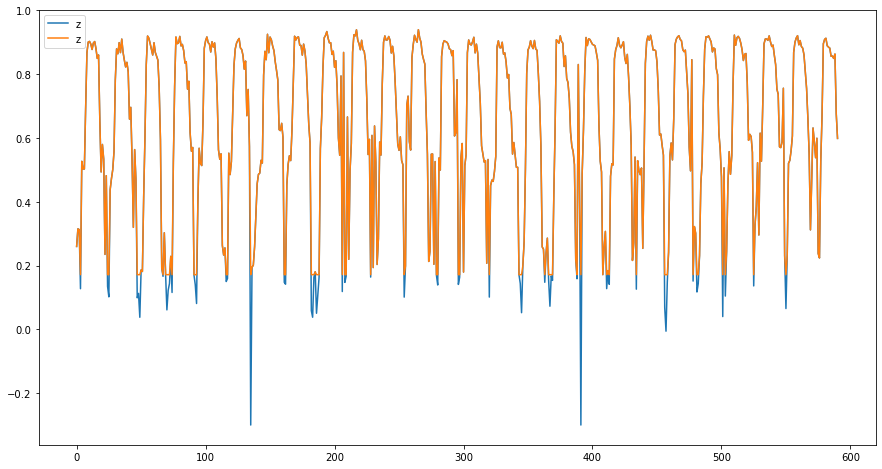

In [14]:
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(a, label='z')
ax.plot(b, label='z')
ax.legend()

In [13]:
# create weights
w = np.array((whoe_year!=-0.3)*1,dtype='double')

# apply filter
z = ws2d(whoe_year,5000,w)

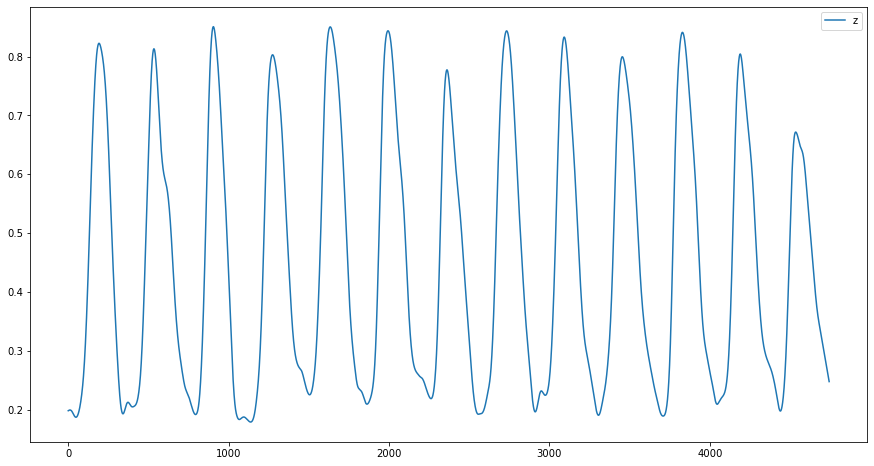

In [14]:
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z, label='z')
ax.legend()

In [15]:
# create weights
w = np.array((whoe_year!=-0.3)*1,dtype='double')
lrange = array.array('d',np.linspace(0,6,1000))

# apply filter
z, loptv = ws2doptv(whoe_year,w,lrange)

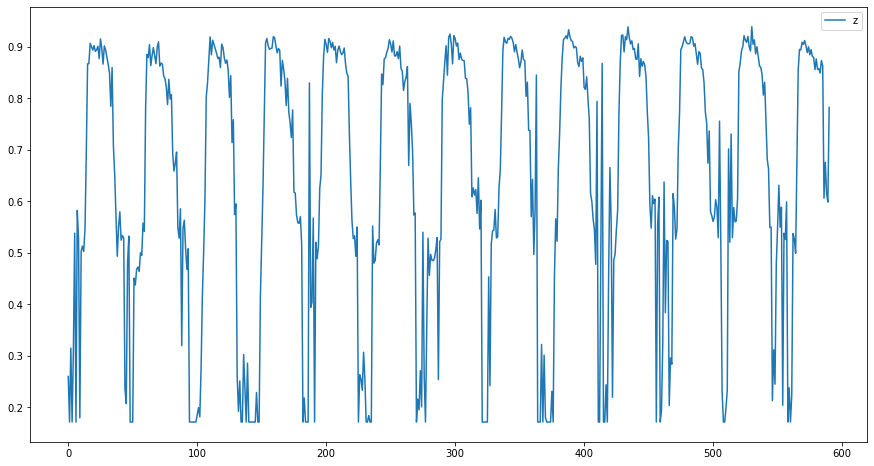

In [21]:

# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(whoe_year[whoe_year>-0.3], label='z')
ax.legend()

133698.37418249476


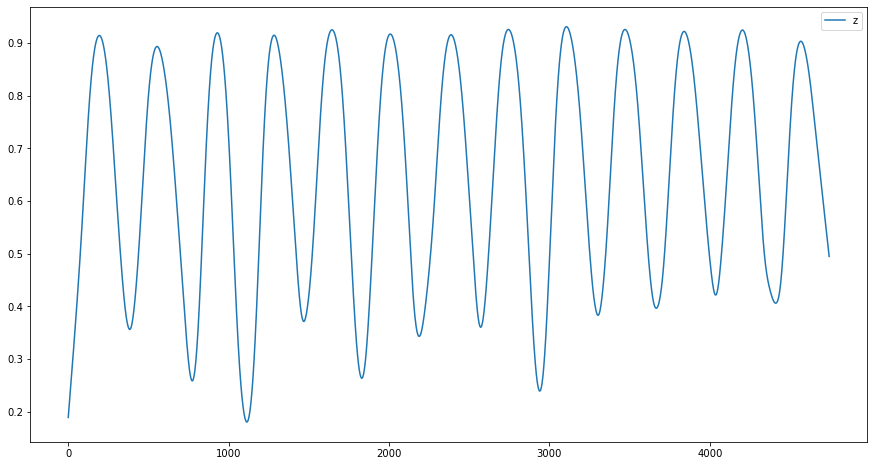

In [22]:
print(loptv)
# plot time series of pixel
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z, label='z')
ax.legend()

In [28]:
np.array(z).shape

(4745,)

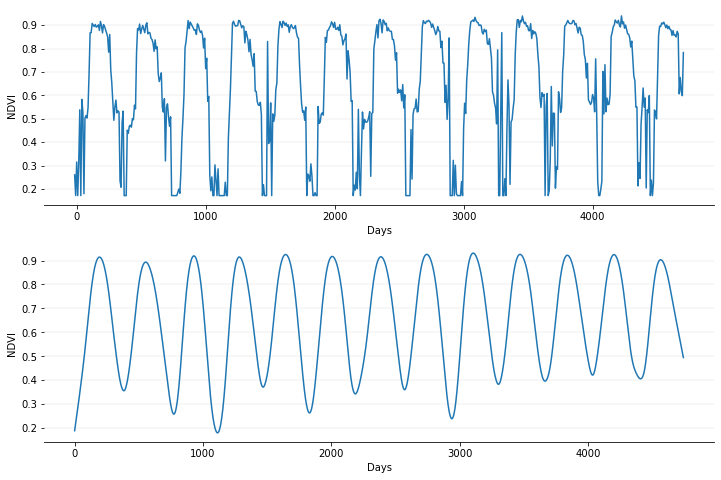

In [42]:
# plot time series of pixel
fig, ax = plt.subplots(2,1,figsize=(12, 8))

ax[0].plot(whoe_year[whoe_year>-0.3], label='z')

#specify x-axis locations
x_ticks = [2, 127, 252, 377, 502]

#specify x-axis labels
x_labels = range(0,4745,1000)

#add x-axis values to plot
ax[0].set_xticks(ticks=x_ticks, labels=x_labels)

ax[0].set_ylabel('NDVI')
ax[0].set_xlabel('Days')

# Add major gridlines in the y-axis
ax[0].grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
    

ax[1].plot(z, label='z')
ax[1].set_ylabel('NDVI')
ax[1].set_xlabel('Days')

# Add major gridlines in the y-axis
ax[1].grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)

plt.savefig('/home/philipp/Data/modis/graphs/whittaker.png', dpi=300)

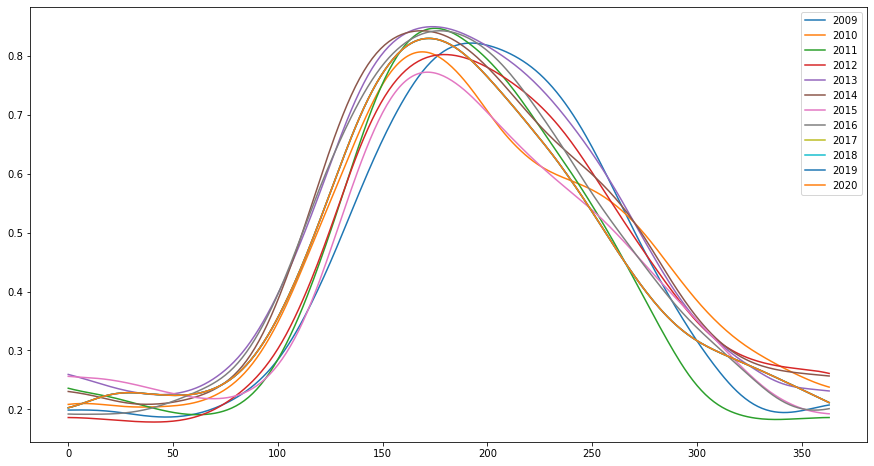

In [17]:
x = 0
y = 365

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(z[x+1:x+y], label='2009')
ax.plot(z[x+y*1+1:x+y*2], label='2010')
ax.plot(z[x+y*2+1:x+y*3], label='2011')
ax.plot(z[x+y*3+1:x+y*4], label='2012')
ax.plot(z[x+y*4+1:x+y*5], label='2013')
ax.plot(z[x+y*5+1:x+y*6], label='2014')
ax.plot(z[x+y*6+1:x+y*7], label='2015')
ax.plot(z[x+y*7+1:x+y*8], label='2016')
ax.plot(z[x+y*8+1:x+y*9], label='2017')
ax.plot(z[x+y*8+1:x+y*9], label='2018')
ax.plot(z[x+y*8+1:x+y*9], label='2019')
ax.plot(z[x+y*8+1:x+y*9], label='2020')
ax.legend()

In [18]:
# path to hdf5 file
path_hdf5 = '/home/philipp/Data/modis/modis_smooth.h5'

# create / open file
hdf5_modis = h5py.File(path_hdf5, 'a')

if not os.path.isfile(path_hdf5):
    print('file not found -> creating file')
    
    # create dataset
    hdf5_modis.create_dataset('whittaker',\
                          (images.shape[0], images.shape[1], (end_year-start_year+1)*365),\
                          dtype=np.float32)

In [19]:
hdf5_modis['whittaker']

<HDF5 dataset "whittaker": shape (1299, 1864, 4745), type "<f4">

In [20]:
def smooth_whittaker(image):

    # select one pixel
    a = image/10000
    
    # set everting below quantile 0.1 to the value of quantile 0.1
    a[a<np.quantile(a, 0.1)] = np.quantile(a, 0.1)
    
    # create 1D array
    whoe_year = np.ones(365*(end_year-start_year+1))*-0.3

    # fill data from modis
    whoe_year[idx_src-1] = a

    # create weights
    w = np.array((whoe_year!=-0.3)*1,dtype='double')
    lrange = array.array('d',np.linspace(0,6,100))

    # apply filter
    z, loptv = ws2doptv(whoe_year,w,lrange)
    
    z = np.nan_to_num(np.array(z), -0.3)
    z[z<-0.3] = -0.3
    z[z>1] = 1

    return z

In [21]:
for y in range(images.shape[0]):
    print(y)
    for x in range(images.shape[1]):
        hdf5_modis['whittaker'][y,x,:] = smooth_whittaker(images[y,x])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [22]:
hdf5_modis.close()